In [2]:
import pandas as pd
import time
from pathlib import Path
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 2)
sns.set(rc={'figure.figsize':(25,15)})

In [3]:
def time_count(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        f = func(*args, **kwargs)
        end = time.time()
        print(f'time elapsed:{end - start}')
        return f
    return wrapper

In [47]:
df_main = pd.DataFrame()
#cols =['date','prices', 'market_caps', 'total_volumes']
@time_count
def concat_dfs(path = 'Gecko_coins_from_2017buble_top200/'):
    
    global df_main
    
    p =path
    
    for file in Path(p).glob('*.csv'):
        ticker = str(file).split('\\')[-1].split('_')[0]
        
        df_coin_data = pd.read_csv(file, index_col='date', parse_dates=True).rename(columns={'prices': f'{ticker}_cl', 
                                                                                         'market_caps':f'{ticker}_mktcap',
                                                                                         'total_volumes':f'{ticker}_vol'}
                                                                               )
        df_coin_data.index = df_coin_data.index.date
        df_main = pd.concat([df_main,df_coin_data],axis=1, join='outer' )
        
    return df_main

In [48]:
all_symbols = concat_dfs()

time elapsed:1.5197062492370605


#### Tworze dataframe z okeresu sprzed i po bance z 2017, oraz wyznaczam date szczytu bitcoina jako referencyjną. 

In [49]:
# Tworze dataframe z okeresu sprzed i po bance z 2017, oraz data szczytu bitcoina jako referencyjną
bubble_period = all_symbols.loc[all_symbols.index>=pd.to_datetime('2017-11-01')]
btc_highest_price = bubble_period['bitcoin_cl'].max()
btc_highest_price_date = bubble_period.loc[bubble_period['bitcoin_cl']== btc_highest_price].index[0]

#### Tworzę dataframe ze stopami zwrotów dla cen zamknięcia i market cap z okresu bańki

In [50]:
coins_pct_returns = bubble_period.filter(regex="_mktcap$|_cl$", axis=1).apply(lambda x:((x.pct_change()+1).cumprod()-1)*100)


##### Tworzę dataframe kiedy i jakie były maksymalne wartości cen zamknięcia. Potem dodaję stopę zwrotu z tego dnia dla mkt_cap i dla ceny zamknięcia gdybyśmy kupili 2017-11-01 (data zalozona przeze mnie):

In [51]:
coins_peak_vals = pd.DataFrame(bubble_period.filter(regex='_cl$', axis=1).max()).reset_index().rename(columns={0:'peak_close',
                                                                                               'index':'symbol'})
# modyfikuję nazwy symboli oraz wyrzucam puste wartości(okazuje się że nie dla wszystkich coinów pobrały się dane)

coins_peak_vals.symbol = coins_peak_vals.symbol.apply(lambda x: x.rsplit('_')[0])
coins_peak_vals.dropna(inplace=True)

# funkcje pomocnicze

# 1. Pobiera date dla maksymalnej ceny altcoina z okresu banki
def get_time(x):
    return bubble_period.loc[bubble_period[x]== bubble_period[x].max()].index[-1]

# 2. Kiedy mamy date z pkt 1 pobiera wartosć z dataframe ze stopami zwrotu dla tej daty.   
def get_cell_value(df,date, prefix):
    return coins_pct_returns.loc[date, f'{df.symbol}{prefix}']

# Użycie funkcji pomocniczych:

coins_peak_vals['peak_date'] = coins_peak_vals.apply(lambda x: get_time(x.symbol+'_cl'),axis=1)
coins_peak_vals['peak_m_cap_pct'] = coins_peak_vals.apply(lambda x: get_cell_value(x, x.peak_date, '_mktcap'), axis=1)
coins_peak_vals['peak_cl_pct'] = coins_peak_vals.apply(lambda x: get_cell_value(x, x.peak_date, '_cl'), axis=1)

# Największa stopa zwrotu dla BTC
btc_cl_return = coins_peak_vals.peak_cl_pct.loc[coins_peak_vals.symbol == 'bitcoin'].values[0]

#### Tworzę dataframe stóp zwrotu altcoinow w momencie szczytu bitcoina 

In [52]:

coins_vals_from_btc_peak = pd.DataFrame(coins_peak_vals.symbol) 
coins_vals_from_btc_peak['mkt_cap_pcy'] = coins_peak_vals.apply(lambda x: get_cell_value(x,btc_highest_price_date, '_mktcap')
                                                            , axis=1) 
coins_vals_from_btc_peak['close_pct'] = coins_peak_vals.apply(lambda x: get_cell_value(x,btc_highest_price_date, '_cl')
                                                            , axis=1) 

#### Tworzę listę alctoinow z początkowa ceną wg której dokonam podziału na przedziały cenowe

In [53]:
start_prices = bubble_period.loc[bubble_period.index[0]].filter(regex='_cl$') # pierwsze ceny pochodzą z 01-11-2017
start_prices.index = start_prices.index.map(lambda x: x.split('_')[0]) # usunięcie prefiksu
start_prices['earthcoin'] = 0.000079 # wyszukałem i dodałem ręcznie bo dla tego coina pierwsza cena pojawiła się później
start_prices.sort_values()

fedoracoin         1.71e-06
infinitecoin       9.23e-06
veros              2.12e-05
mooncoin           2.15e-05
earthcoin          7.90e-05
                     ...   
bitcoin            6.71e+03
atmos                   NaN
colossuscoin-v2         NaN
mercury                 NaN
vpncoin                 NaN
Name: 2017-11-01, Length: 135, dtype: float64

In [54]:
# podział coinów względem ceny, z kazdego uzyskuje listę symboli

coins_to_1 = start_prices[start_prices<=1].index
coins_1_to_10 = start_prices[(start_prices>1) & (start_prices<=10)].index
coins_10_to_100 = start_prices[(start_prices>10) & (start_prices<=100)].index
coins_100_to_1000 = start_prices[(start_prices>100) & (start_prices<=1000)].index
coins_above_1000 = start_prices[start_prices>1000].index

#### Stopy zwrotów wg podziału na ceny

In [55]:
coins_to_1_returns = coins_peak_vals.loc[coins_peak_vals.symbol.isin(coins_to_1)]
coins_to_10_returns = coins_peak_vals.loc[coins_peak_vals.symbol.isin(coins_1_to_10)]
coins_to_100_returns = coins_peak_vals.loc[coins_peak_vals.symbol.isin(coins_10_to_100)]
coins_to_1000_returns = coins_peak_vals.loc[coins_peak_vals.symbol.isin(coins_100_to_1000)]
coins_above_1000_returns = coins_peak_vals.loc[coins_peak_vals.symbol.isin(coins_above_1000)]

#### Funkcja pomocnicza do wykresów

In [56]:

def plot_returns(df):
    fig, ax = plt.subplots(figsize=(20,8))
    cls_returns = sns.scatterplot(data=df, ax=ax, x=df.peak_date, y=df.peak_cl_pct)
    cls_returns.set(xlabel='daty szczytów', ylabel='stopa zwrotu [%]')
    
    plt.axvline(btc_highest_price_date, ls='-.', lw=0.7, color='red')
    plt.text(x=btc_highest_price_date, y=df.peak_cl_pct.max(), s=' BTC peak 16DEC', color='red')
    
    btc_data = coins_pct_returns['bitcoin_cl'].loc[min(df.peak_date.min(),
                                           btc_highest_price_date):df.peak_date.max()]
    
    ax.plot(btc_data, color='red',lw=0.7, alpha=0.7, label='BTC close return')
    ax.legend(loc='upper left')
    ax.plot(btc_highest_price_date, btc_cl_return,marker='o',color='red') 
    plt.text(x=btc_highest_price_date, y = btc_cl_return, s=f'  st_zwr {btc_cl_return:.2f}',color='red')
    
    for x, y, z in zip(df.peak_date, df.peak_cl_pct, df.symbol):
        plt.text(x=x,y=y,s = f'  {z}')


### SZCZYTY COINOW 

#### COINY DO 1 DOLARA

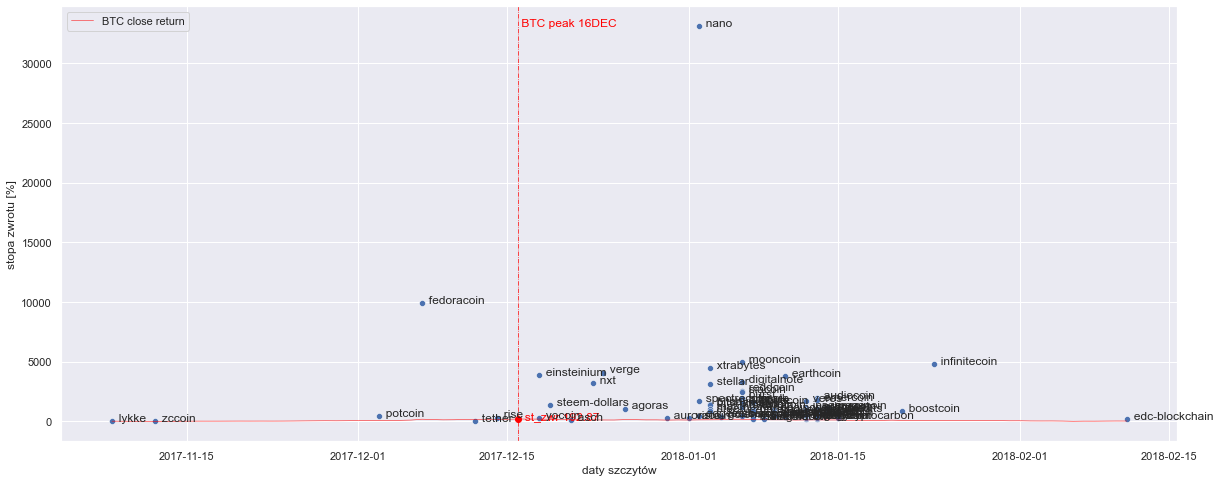

In [57]:
plot_returns(coins_to_1_returns)

#### COINY DO 10$

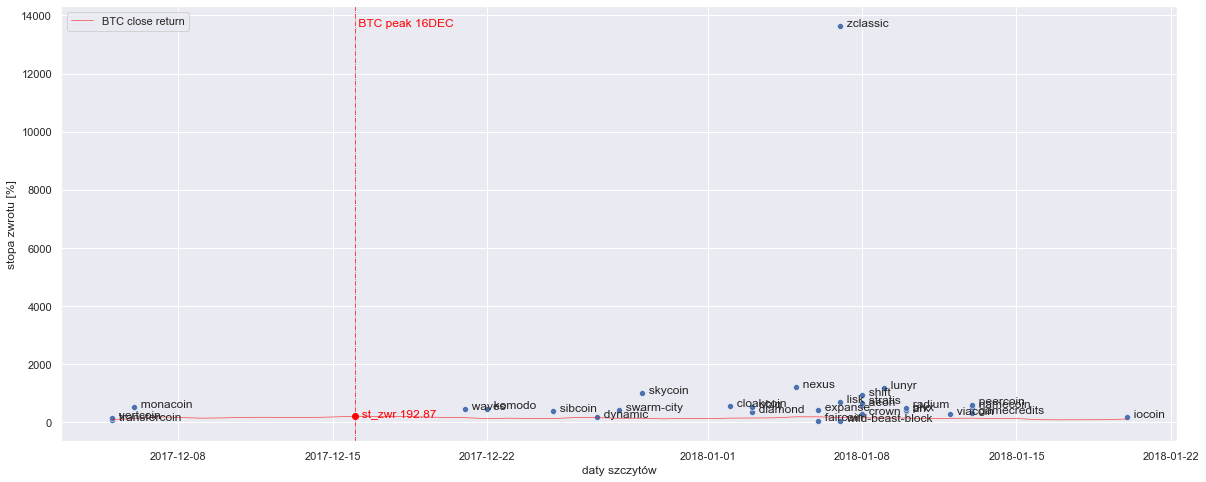

In [22]:
plot_returns(coins_to_10_returns)

####  COINY DO 100$

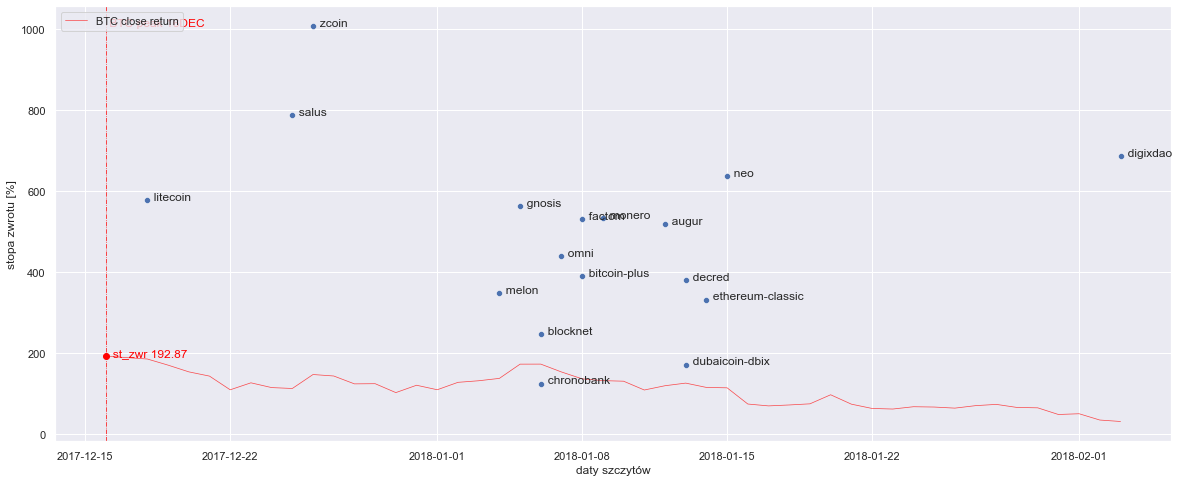

In [23]:
plot_returns(coins_to_100_returns)

#### COINY DO 1000$

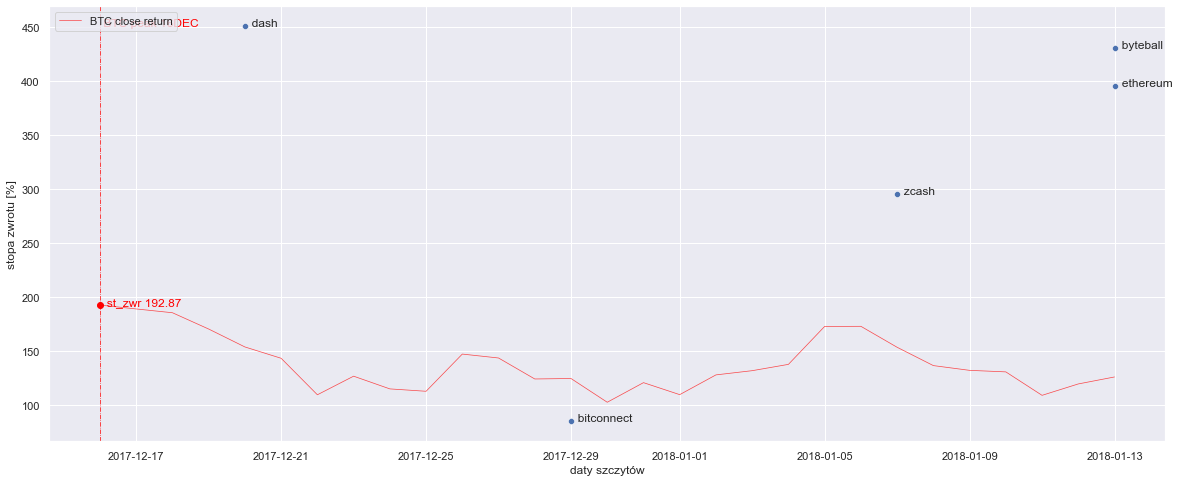

In [24]:
plot_returns(coins_to_1000_returns)

### WYNIKI COINOW Z DNIA SZCZYTU BTC

#### Analogicznie jak wyżej

In [58]:
coins_to_1_btc_peak_returns = coins_vals_from_btc_peak.loc[coins_vals_from_btc_peak.symbol.isin(coins_to_1)]
coins_to_10_btc_peak_returns = coins_vals_from_btc_peak.loc[coins_vals_from_btc_peak.symbol.isin(coins_1_to_10)]
coins_to_100_btc_peak_returns = coins_vals_from_btc_peak.loc[coins_vals_from_btc_peak.symbol.isin(coins_10_to_100)]
coins_to_1000_btc_peak_returns = coins_vals_from_btc_peak.loc[coins_vals_from_btc_peak.symbol.isin(coins_100_to_1000)]
coins_above_1000_btc_peak_returns = coins_vals_from_btc_peak.loc[coins_vals_from_btc_peak.symbol.isin(coins_above_1000)]

In [59]:
def plot_returns_for_btc_peak(df):
    fig, ax = plt.subplots(figsize=(20,8))
    df = df.sort_values(by='close_pct', ascending=False)
    returns = sns.barplot(data=df, ax=ax, x=df.symbol, y=df.close_pct)
    returns.set(xlabel='', ylabel='stopa zwrotu [%]')
    returns.set_xticklabels(returns.get_xticklabels(),rotation=30)
    
    plt.axhline(btc_cl_return, ls='-.', lw=0.7, color='red')
    plt.text(y=btc_cl_return, x = len(df), s=f'BTC {btc_cl_return:.1f}%', color='red')
    
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(x= bar.get_x()+(bar.get_width()/2), y=height, s=f'{height:.1f}', ha='center')

#### COINY DO 1 DOLARA

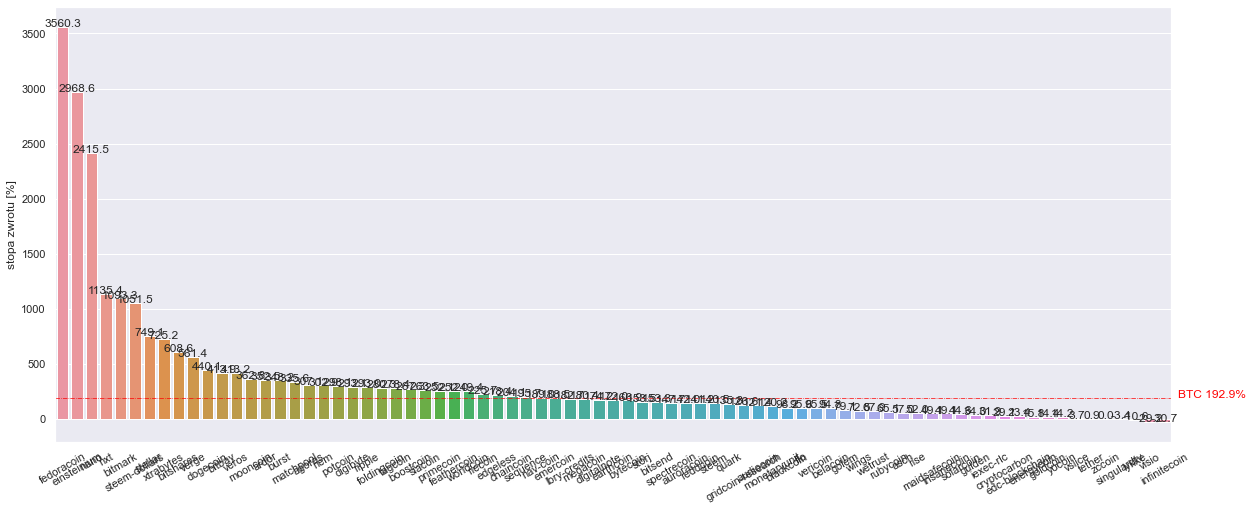

In [60]:
plot_returns_for_btc_peak(coins_to_1_btc_peak_returns)

#### COINY DO 10$ 

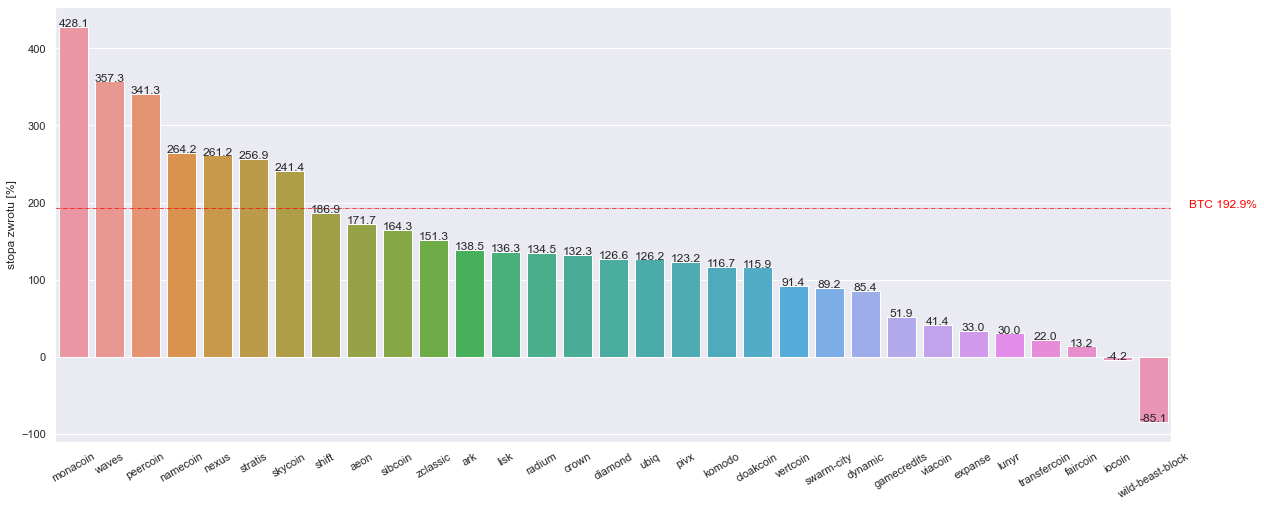

In [28]:
plot_returns_for_btc_peak(coins_to_10_btc_peak_returns)

#### COINY DO 100$

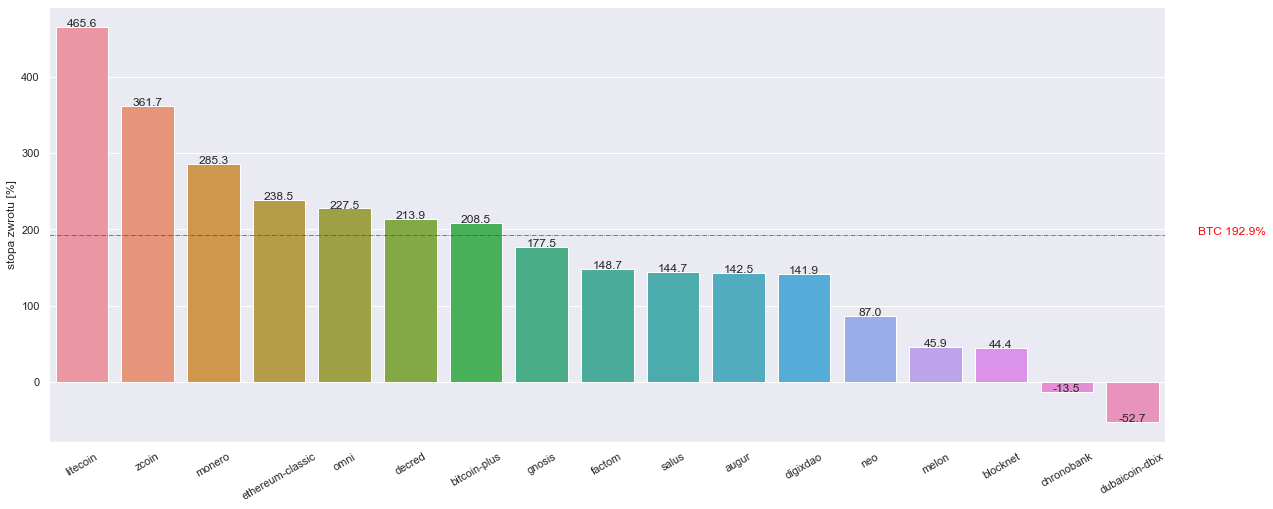

In [29]:
plot_returns_for_btc_peak(coins_to_100_btc_peak_returns)

#### COINY DO 1000$

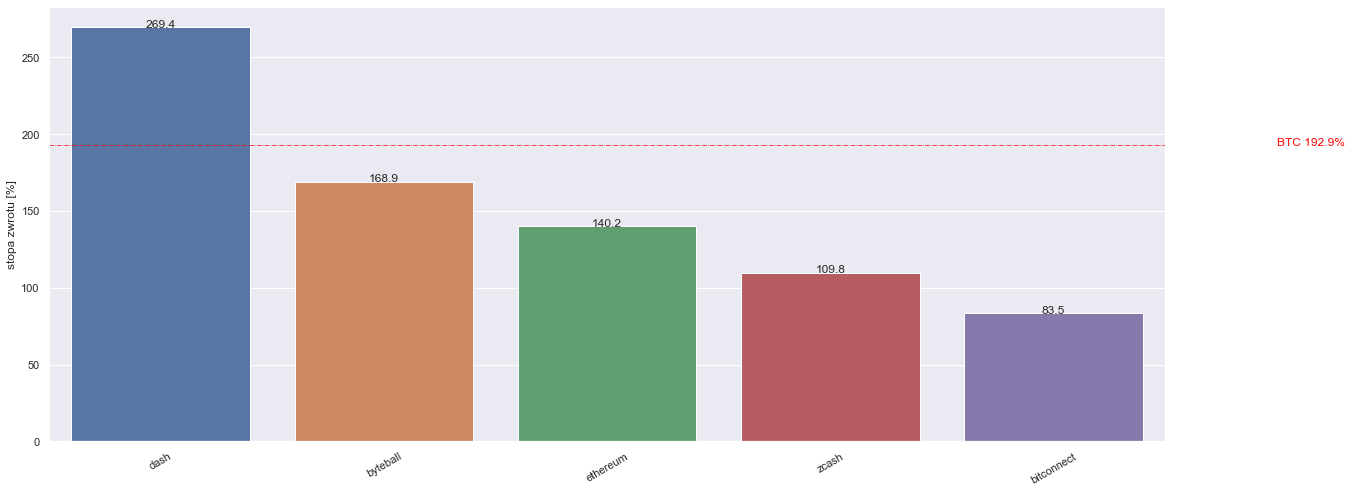

In [30]:
plot_returns_for_btc_peak(coins_to_1000_btc_peak_returns)

#### Wykresy stóp zwrotu dla 10 najlepszych coinów z danego przedziału cenowego + BTC

In [31]:
def get_cols(df, prefix):
    
    top_coins= df.nlargest(10, columns=['peak_cl_pct']).symbol.to_list()
    top_coins=[symbol+prefix for symbol in top_coins]
    
    cols = [column for column in coins_pct_returns.columns if column in top_coins]
    return cols

def plot_lines(df):
    fig, ax = plt.subplots(figsize=(25,15))
    line_chart = sns.lineplot(data=df)
    ax.plot(coins_pct_returns.bitcoin_cl, lw=1.5, color='purple')
    plt.text(x=df.index[-1], y=coins_pct_returns.bitcoin_cl[-1], s=' BTC', color='purple')

#### Coiny do 1$ 

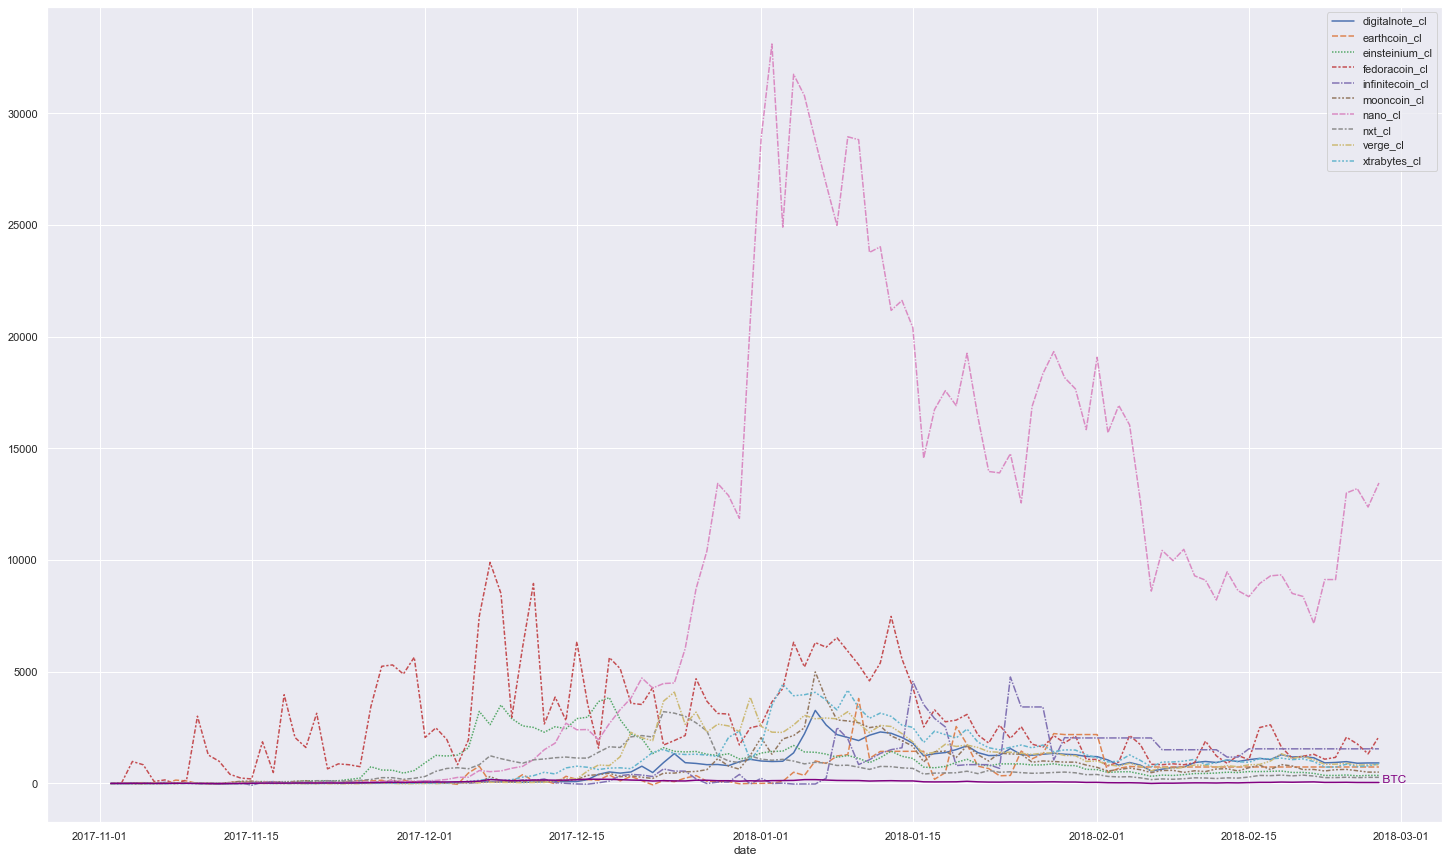

In [32]:

plot_1dollar = plot_lines(df=coins_pct_returns[get_cols(df=coins_to_1_returns, prefix='_cl')])

#### do 10$ (można wywalić tego zclassic zeby nie psuł wykresu)

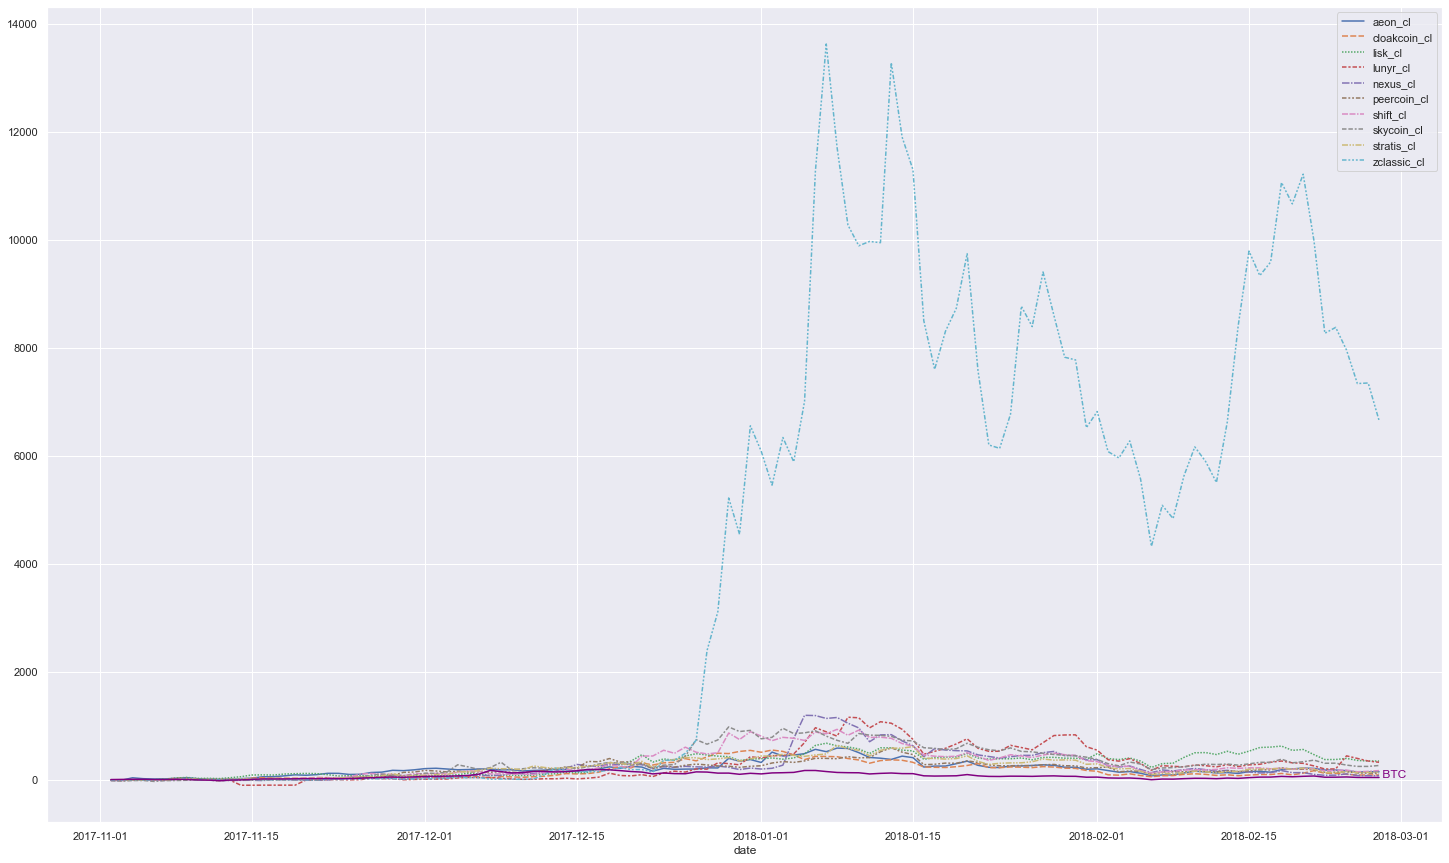

In [33]:
plot_10dollar = plot_lines(df=coins_pct_returns[get_cols(df=coins_to_10_returns, prefix='_cl')])

####  do 100$

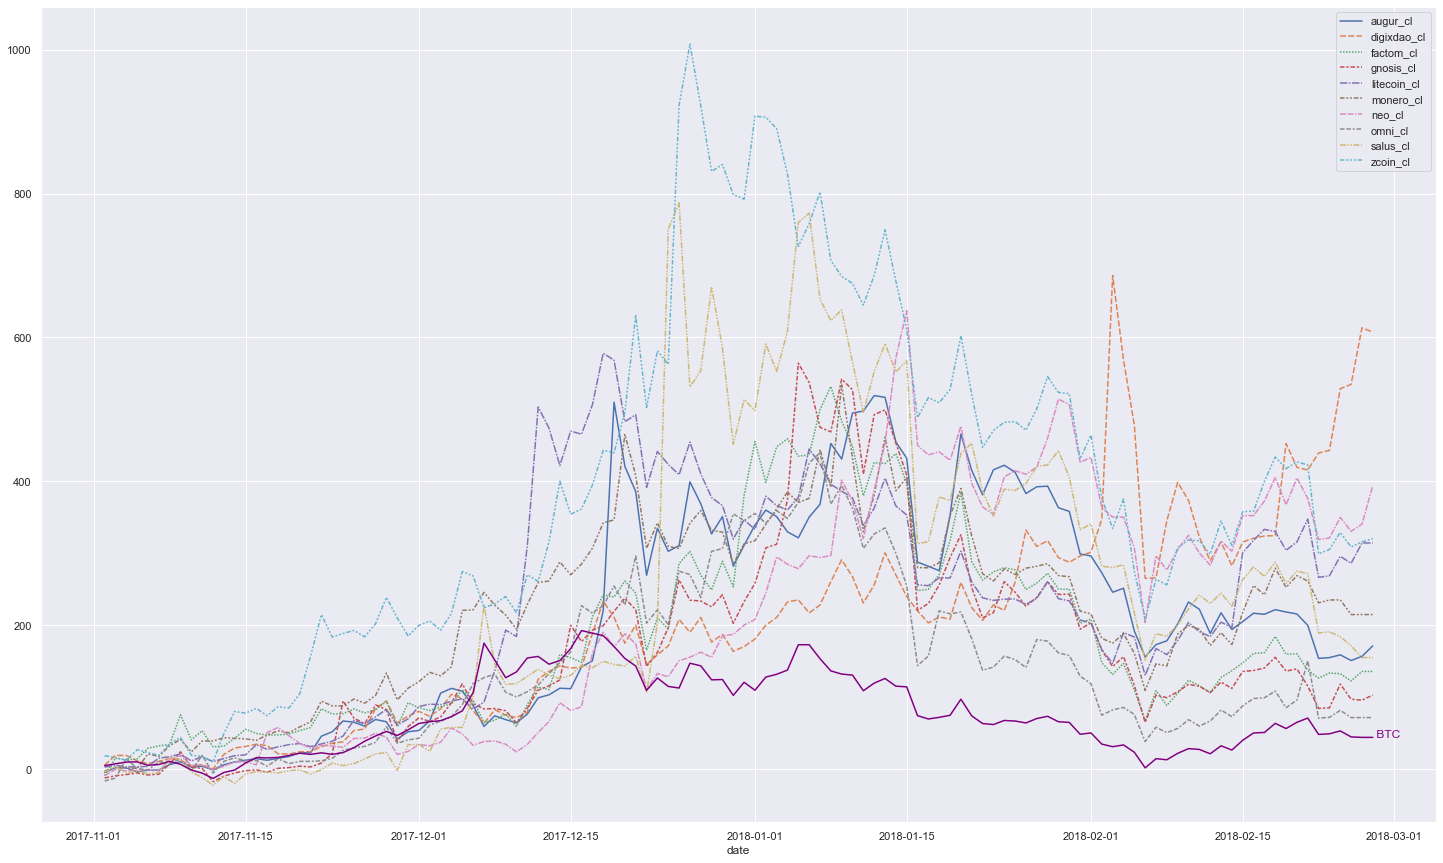

In [34]:
plot_100dollar = plot_lines(df=coins_pct_returns[get_cols(df=coins_to_100_returns, prefix='_cl')])

#### do 1000$

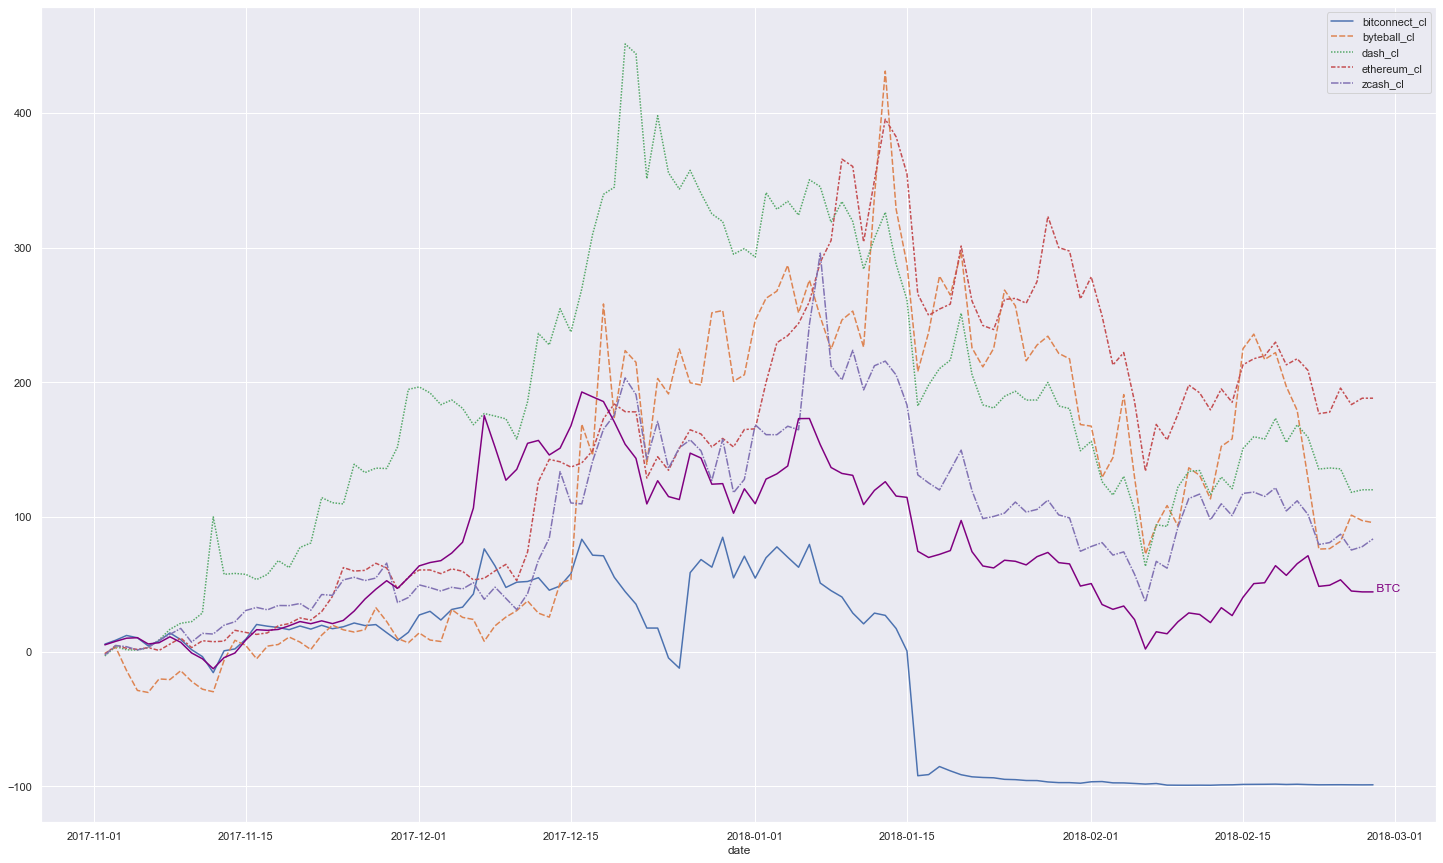

In [35]:
plot_1000dollar = plot_lines(df=coins_pct_returns[get_cols(df=coins_to_1000_returns, prefix='_cl')])

### DRAWDOWNY

In [61]:
# Tworzenie dataframe
drawdowns = bubble_period.filter(regex="_cl$", axis=1).apply(lambda x:((x-x.cummax())/x.cummax())*100)
drawdowns.columns = drawdowns.columns.map(lambda x: x.split('_')[0])

In [62]:
drawdowns.tail()

,aeon,agoras,ardor,ark,asch,atmos,audiocoin,augur,auroracoin,belacoin,...,wetrust,wild-beast-block,wings,worldcoin,xtrabytes,yocoin,zcash,zccoin,zclassic,zcoin
2018-02-23,-59.05,-52.05,-80.32,-62.86,-48.21,-70.95,-83.19,-58.78,-18.71,-66.72,...,-80.10,NaN,-71.36,-79.50,-81.56,-73.86,-54.27,-58.95,-38.23,-63.39
2018-02-24,-60.87,-70.03,-78.96,-60.96,-46.40,-63.88,-83.02,-58.16,-20.01,-67.31,...,-77.65,NaN,-70.59,-78.49,-78.81,-78.97,-52.71,NaN,-41.30,-61.26
2018-02-25,-64.27,-72.17,-80.20,-64.21,-46.26,-69.21,-83.71,-59.43,-22.84,-71.36,...,-79.54,NaN,-65.76,-80.35,-81.16,-80.99,-55.67,-60.07,-45.81,-63.08
2018-02-26,-63.62,-73.38,-79.23,-63.26,-44.51,-68.95,-83.52,-58.51,-22.85,-71.02,...,-79.39,NaN,-60.67,-78.32,-80.35,-83.06,-55.04,-59.14,-45.73,-62.45
2018-02-27,NaN,NaN,-79.37,-62.64,-41.51,-69.13,-84.42,-56.14,NaN,NaN,...,-77.49,NaN,-62.77,NaN,-78.23,-64.94,-53.58,NaN,-50.78,-62.03


In [63]:
# Tworzenie statystyk
def categorize_coins(x):
    if x.symbol in coins_to_1:
        return 'coins_to_1'
    elif x.symbol in coins_1_to_10:
        return 'coins_to_10'
    elif x.symbol in coins_10_to_100:
        return 'coins_to_100'
    elif x.symbol in coins_100_to_1000:
        return 'coins_to_1000'
    elif x.symbol in coins_above_1000:
        return 'coins_above_1000'
    
min_vals = pd.Series(drawdowns.min(), name='max_dd')
min_date = pd.Series(drawdowns.idxmin(), name='date')

dd_stats = pd.concat([min_vals,min_date], axis=1).reset_index()
dd_stats.rename(columns={'index':'symbol'}, inplace=True)
dd_stats.symbol = dd_stats.symbol.apply(lambda x: x.split('_')[0])
dd_stats['price_range'] = dd_stats.apply(lambda x: categorize_coins(x), axis=1)


In [64]:
dd_stats

,symbol,max_dd,date,price_range
0,aeon,-74.53,2018-02-06,coins_to_10
1,agoras,-73.38,2018-02-26,coins_to_1
2,ardor,-80.53,2018-02-06,coins_to_1
3,ark,-68.07,2018-02-06,coins_to_10
4,asch,-56.84,2018-02-06,coins_to_1
...,...,...,...,...
130,yocoin,-83.06,2018-02-26,coins_to_1
131,zcash,-65.39,2018-02-06,coins_to_1000
132,zccoin,-78.23,2018-02-10,coins_to_1
133,zclassic,-67.77,2018-02-06,coins_to_10


In [65]:
statsy_general=dd_stats.groupby('price_range').agg(
                                    coin_num =("symbol", "count"),
                                    max_dd=("max_dd", min),
                                    min_dd=("max_dd", max),
                                    mean_dd= ("max_dd", "mean"),
                                    std = ("max_dd", "std"),
                                    median_dd = ("max_dd", "median"),
                                    most_freq_date=("date", lambda x: x.value_counts().idxmax()),
                                    num_of_occur = ("date", lambda x: x.value_counts().max())
                                    
                                   
                                   
                                   )

In [66]:
statsy_general

,coin_num,max_dd,min_dd,mean_dd,std,median_dd,most_freq_date,num_of_occur
price_range,,,,,,,,
coins_above_1000,1,-65.16,-65.16,-65.16,NaN,-65.16,2018-02-06,1
coins_to_1,77,-95.43,-8.89,-77.60,11.96,-80.35,2018-02-06,51
coins_to_10,31,-99.97,-57.61,-73.80,8.56,-73.22,2018-02-06,24
coins_to_100,17,-82.29,-53.53,-67.16,7.92,-66.94,2018-02-06,15
coins_to_1000,5,-99.51,-52.75,-71.10,17.25,-67.52,2018-02-06,4


### Drawdown heatmapa 

<AxesSubplot:>

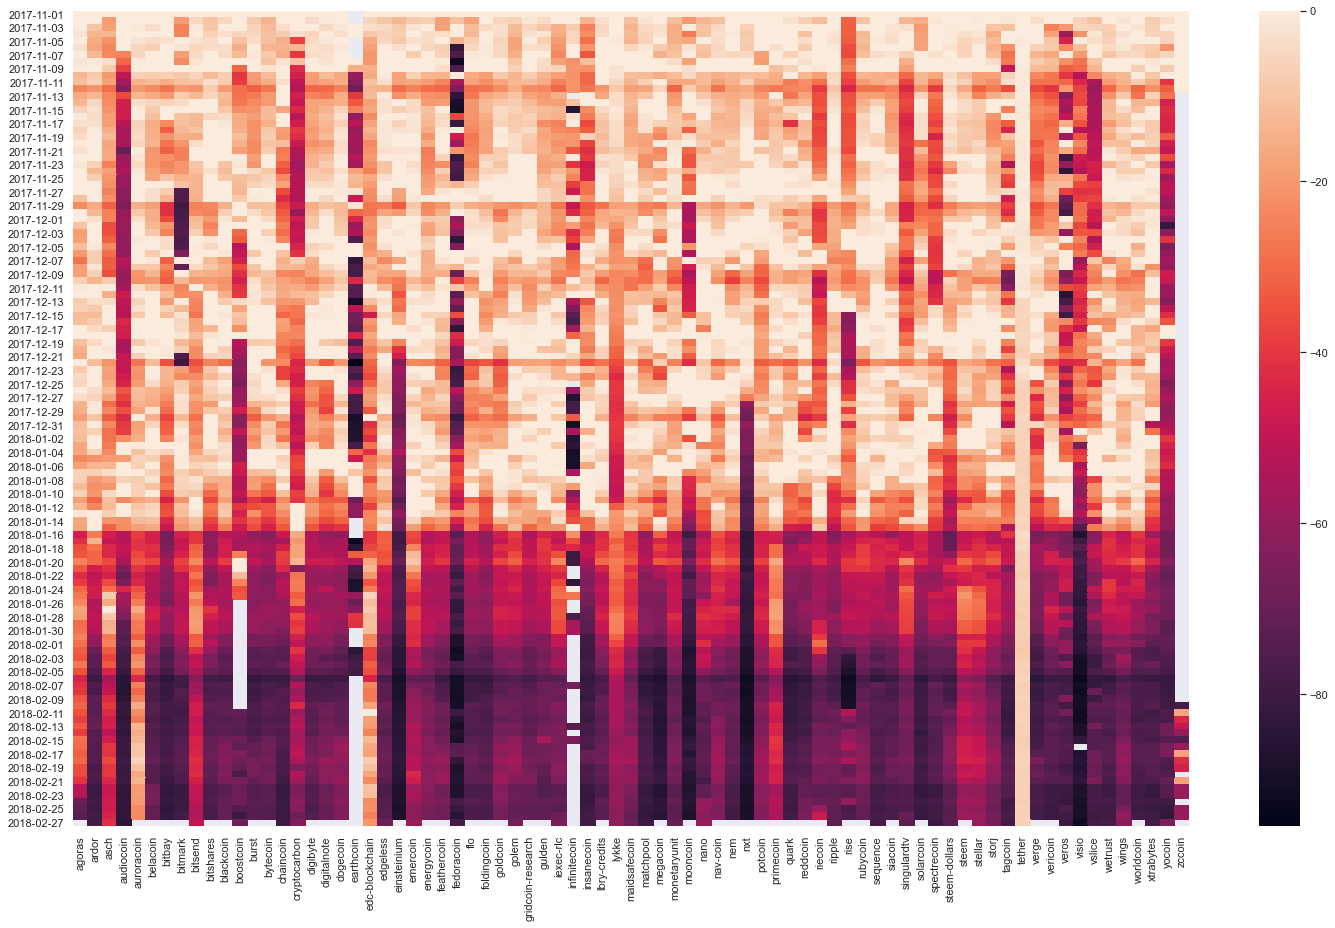

In [67]:
sns.heatmap(drawdowns[coins_to_1])

<AxesSubplot:>

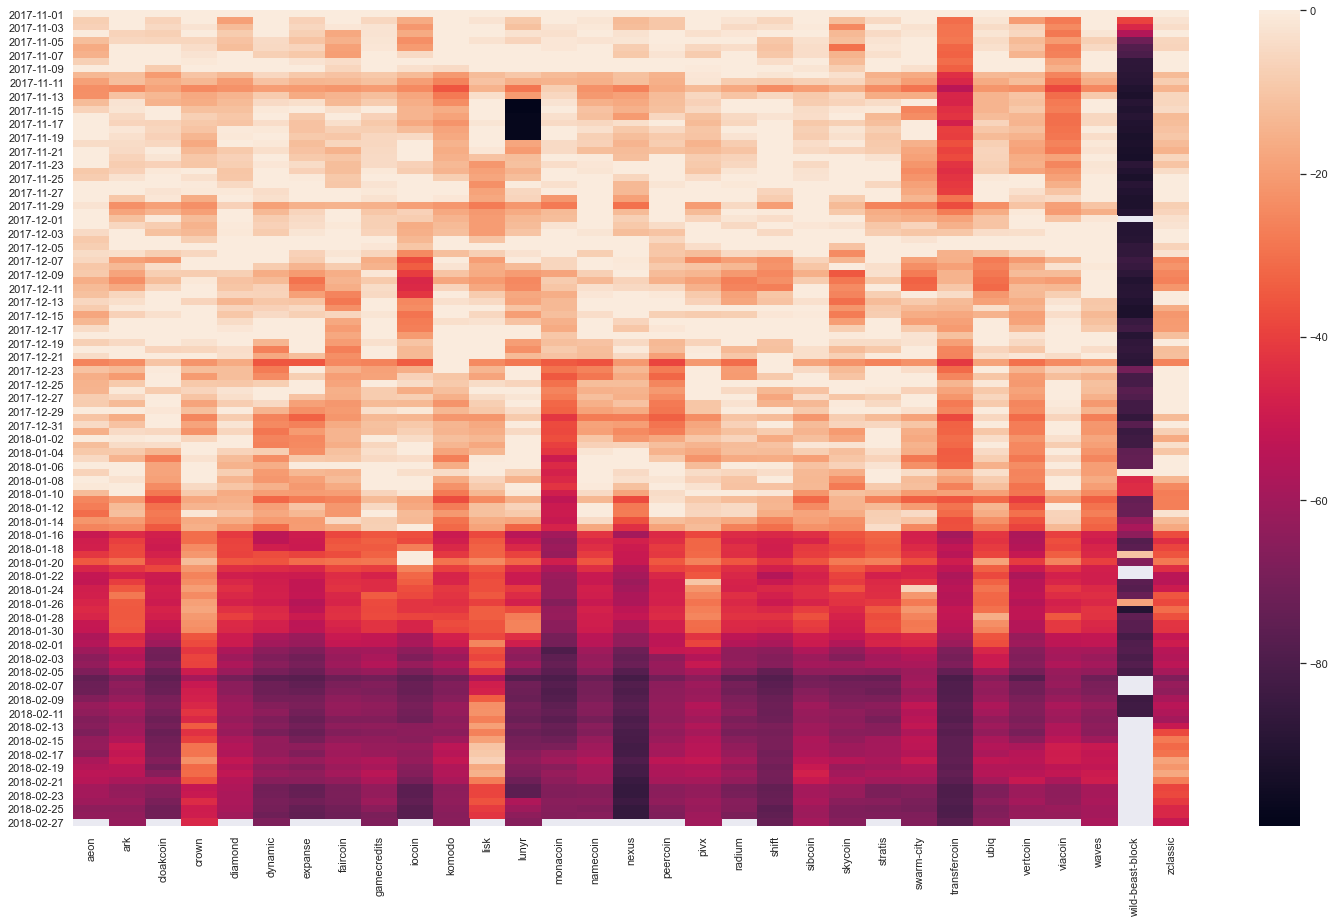

In [68]:

sns.heatmap(drawdowns[coins_1_to_10])

<AxesSubplot:>

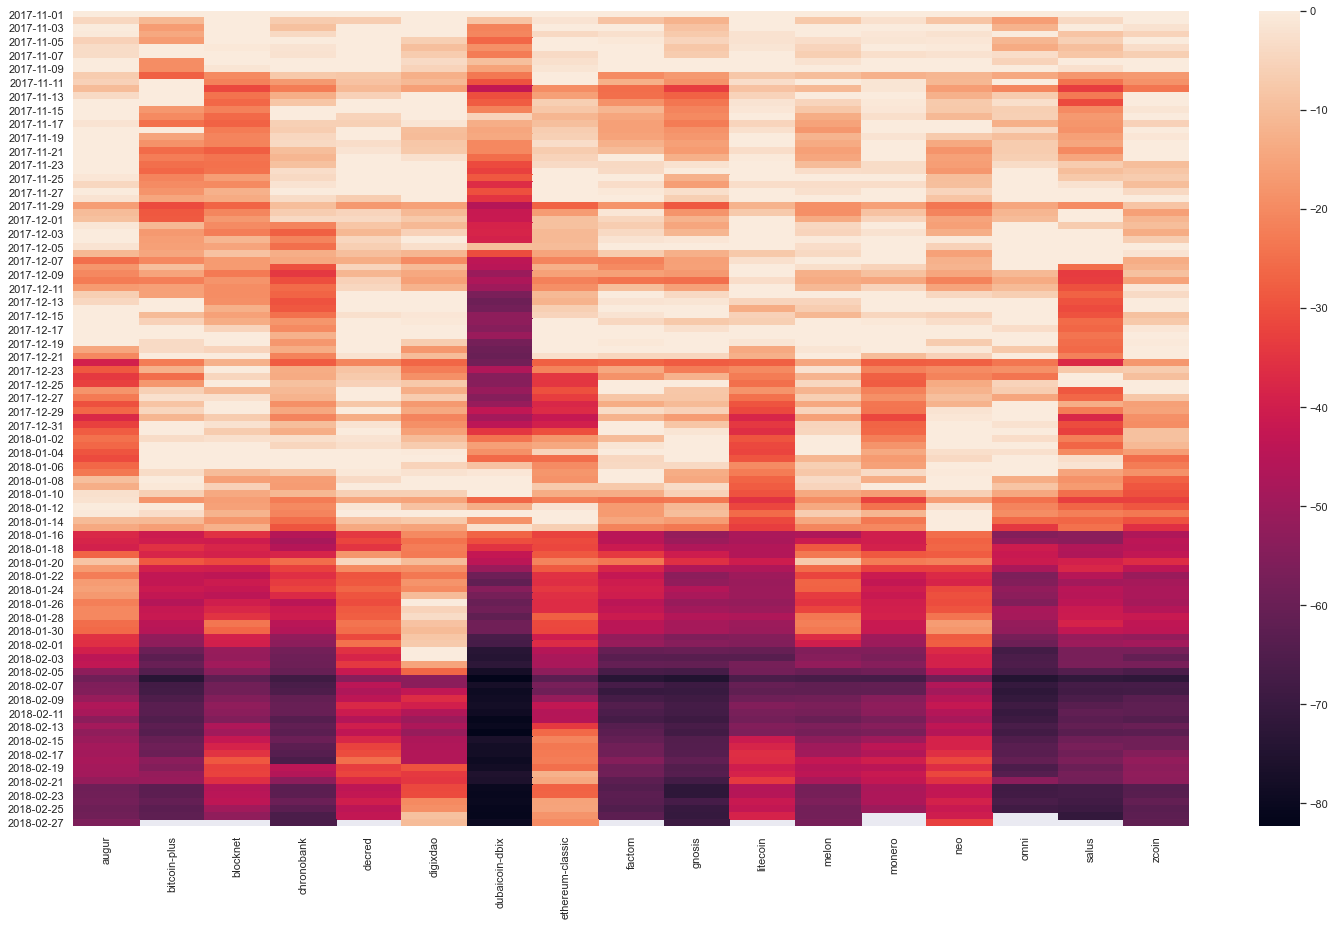

In [69]:
sns.heatmap(drawdowns[coins_10_to_100])

<AxesSubplot:>

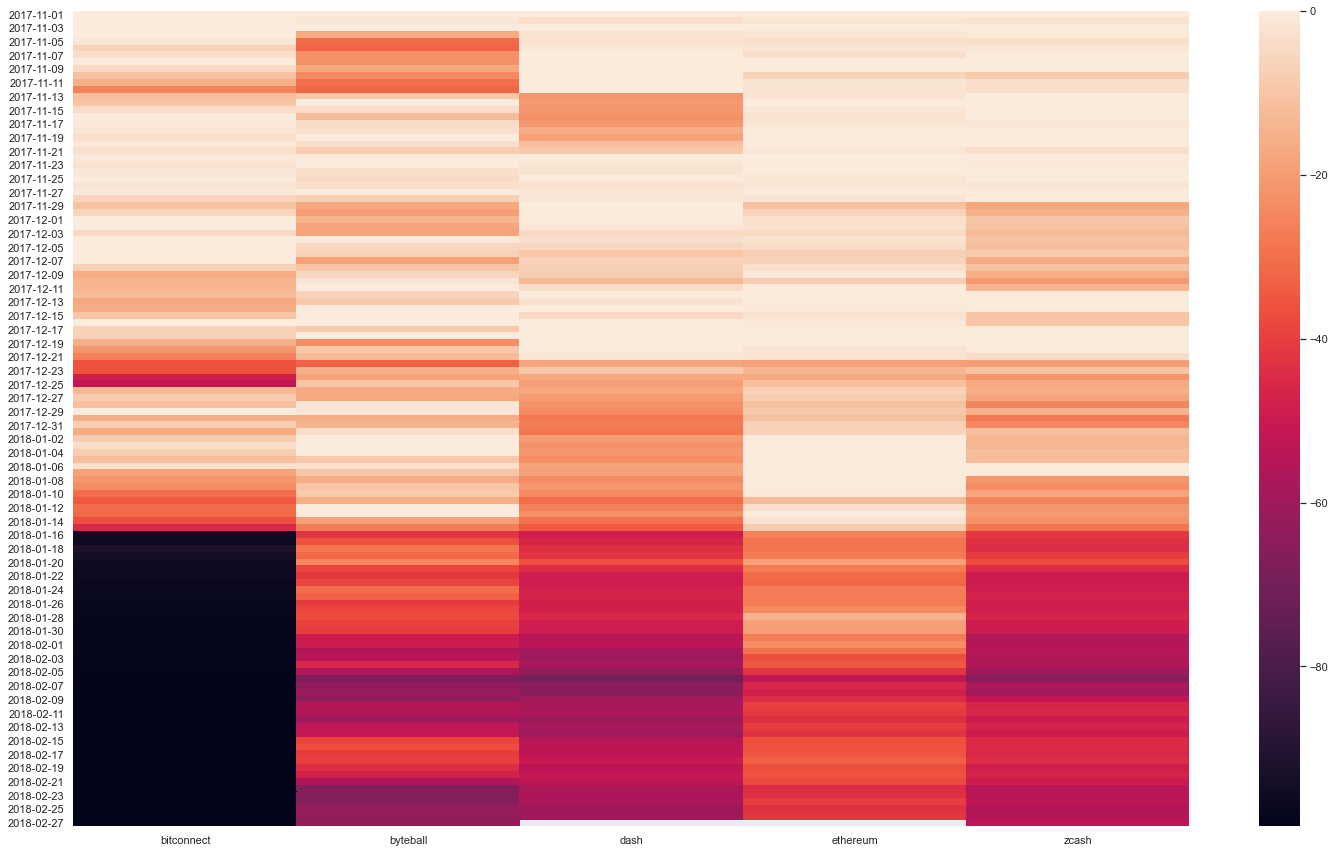

In [70]:
sns.heatmap(drawdowns[coins_100_to_1000])

### MarketCap

In [71]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) # ustawiam opcje żeby wyswietlaly sie lepiej liczby mkt_cap

##### Tworzę dataframe z marketcapami z pierwszego dnia z analizy 2017-11-01 oraz ranking wg wielkości mkt_cap z tego dnia

In [72]:
mc = pd.DataFrame(bubble_period.filter(regex = '_mktcap$').iloc[0])
mc.rename(columns={mc.columns[0]:'mkt_cap'}, inplace=True)
mc.loc['earthcoin_mktcap']  = 906747.79# dodalem recznie bo wyskakiwał NaN
mc.index= mc.index.map(lambda x: x.split('_')[0])
mc.sort_values(by='mkt_cap', ascending=False, inplace=True)
mc.insert(loc=1, value=range(1,len(mc)+1), column='rank')

##### Poniżej podzielone coiny wg ceny i posortowane wg wielkosci mk_cap z 2017-11-01 (columna rank), dodana maxymalna stopa zwrotu z ceny i mkt_cap

##### Coiny do 1$

In [73]:

m_cap_to_1 = pd.concat([mc.loc[coins_to_1].sort_index(),
           coins_to_1_returns[['symbol','peak_cl_pct','peak_m_cap_pct']].set_index('symbol')], axis=1)
m_cap_to_1.sort_values(by='rank')

,mkt_cap,rank,peak_cl_pct,peak_m_cap_pct
ripple,7480166182.47,3,1650.60,1660.03
nem,1490479755.85,8,1031.88,931.82
stellar,454817309.75,13,3093.38,3341.52
tether,451205462.20,14,7.61,99.72
bytecoin,222738557.60,17,1172.10,1220.00
...,...,...,...,...
fedoracoin,759102.78,126,9901.75,9901.75
insanecoin,715336.32,127,1093.66,1163.30
tagcoin,268557.28,128,415.29,432.32
boostcoin,61880.66,130,838.42,838.42


##### Coiny do 10$

In [74]:
m_cap_1_to_10 = pd.concat([mc.loc[coins_1_to_10].sort_index(),
           coins_to_10_returns[['symbol','peak_cl_pct','peak_m_cap_pct']].set_index('symbol')], axis=1)
m_cap_1_to_10.sort_values(by='rank')

,mkt_cap,rank,peak_cl_pct,peak_m_cap_pct
lisk,501492520.52,12,678.64,662.76
waves,292772000.00,15,449.12,449.12
stratis,287485428.10,16,641.82,612.85
komodo,209904074.58,19,454.92,470.62
ark,207907466.33,20,381.73,381.73
pivx,146763063.19,28,404.70,411.14
monacoin,145811896.07,29,520.48,494.36
vertcoin,136137908.24,30,134.61,184.24
gamecredits,109492908.79,35,291.89,291.89
faircoin,56238493.99,44,42.78,16.52


##### Coiny do 100$

In [75]:
m_cap_10_to_100 = pd.concat([mc.loc[coins_10_to_100].sort_index(),
           coins_to_100_returns[['symbol','peak_cl_pct','peak_m_cap_pct']].set_index('symbol')], axis=1)
m_cap_10_to_100.sort_values(by='rank')

,mkt_cap,rank,peak_cl_pct,peak_m_cap_pct
litecoin,2942709088.95,4,578.15,556.98
neo,1748548610.74,7,637.46,637.46
monero,1349585549.83,9,534.09,325.11
ethereum-classic,994527429.66,10,332.65,341.96
augur,188615900.00,23,519.24,519.24
decred,152456110.72,26,381.67,407.58
digixdao,116116000.00,33,686.17,686.17
factom,100399054.56,36,531.92,539.33
blocknet,84224179.59,39,247.13,216.10
gnosis,73487048.48,41,564.36,564.36


##### Coiny do 1000$

In [76]:
m_cap_100_to_1000 = pd.concat([mc.loc[coins_100_to_1000].sort_index(),
           coins_to_1000_returns[['symbol','peak_cl_pct','peak_m_cap_pct']].set_index('symbol')], axis=1)
m_cap_100_to_1000.sort_values(by='rank')

,mkt_cap,rank,peak_cl_pct,peak_m_cap_pct
ethereum,27411044537.06,2,395.39,398.88
dash,2010644396.71,5,451.24,469.39
bitconnect,1839504000.47,6,85.02,55.75
zcash,562008577.56,11,295.95,371.07
byteball,130325003.30,32,431.09,486.87


,aeon_cl,aeon_mktcap,aeon_vol,agoras_cl,agoras_mktcap,agoras_vol,ardor_cl,ardor_mktcap,ardor_vol,ark_cl,...,zcash_vol,zccoin_cl,zccoin_mktcap,zccoin_vol,zclassic_cl,zclassic_mktcap,zclassic_vol,zcoin_cl,zcoin_mktcap,zcoin_vol
2015-08-04,0.01,74889.00,610.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.01,178442.00,6287.00,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-05,0.01,67344.00,711.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.01,170535.00,7327.00,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-06,0.01,70978.00,685.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.01,170419.00,3264.00,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-07,0.02,189282.00,5101.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.01,159558.00,11421.00,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-08,0.02,165290.00,4012.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.01,167640.00,6528.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
